In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import logging
import glob
from functools import partial
from copy import deepcopy
from toolz import compose, valmap, keyfilter, identity, merge, keymap
from itertools import combinations
import pickle

import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

import sbi
import sbi.utils
import sbi.inference
import sbi.analysis
import sbibm

import swyft
import swyft.utils.constrainedcorner as cc

import tmnre
import tmnre.metrics
import tmnre.benchmark
import tmnre.coverage.oned
from tmnre.nn.resnet import make_resenet_tail
from tmnre.marginalize import filter_marginals_by_dim

In [3]:
def get_10k(x):
    return np.random.permutation(x)[:10000, ...]

def get_xmany(x):
    def getthem(y):
        return np.random.permutation(y)[:x, ...]
    return getthem


TASK_NAME = "torus"
task = sbibm.get_task(
    TASK_NAME,
)

NUM_OBS = 1
theta0 = task.get_true_parameters(NUM_OBS).squeeze()
obs0 = task.get_observation(NUM_OBS).squeeze()

N_SIMULATIONS = [4_985, 11_322, 21_127, 32_032]

In [4]:
mul = 1.75
square = mul * 5.5 / 4 

truth = theta0.flatten().clone().numpy()
truth[-1] -= 0.018

kwargs = dict(
    kde=True,
    bins=75,
    figsize=(square, square),
    space_between_axes=0.25,
    truth=truth,
    ticks=True,
    ticklabels=True,
    ticklabelsize="small",
    labels=[r"$\theta_{" + str(i) + "}$" for i in range(1, task.dim_parameters + 1)],
    labelrotation=50,
)

fittext_kwargs = dict(
    y=0.8,
    fontsize="x-large",
)

In [5]:
posterior_samples = {}
for ns in N_SIMULATIONS:
    # the individually saved paths
    paths = sorted(glob.glob(f"*-{ns:06d}.pickle"))
    paths = list(filter(lambda x: "non" not in x, paths))
    for path in paths:
        key = path.split(".")[0]
        key = key.split("-")[2:]
        key = " ".join(key)
        with open(path, "rb") as f:
            posterior_samples[key] = pickle.load(f)
    
    # the group saved paths
    paths = sorted(glob.glob(f"*-{ns:06d}.pickle"))
    paths = list(filter(lambda x: "non" in x, paths))
    for path in paths:
        n = path.split(".")[0].split("-")[-1]
        with open(path, "rb") as f:
            d = pickle.load(f)
            d = keymap(lambda x: f"{x} {n}", d)
            posterior_samples = merge([posterior_samples, d])
print(posterior_samples.keys())

dict_keys(['SNLE 011322', 'SNPE 011322', 'SNRE 011322', 'SNLE 021127', 'SNPE 021127', 'SNRE 021127', 'SNLE 032032', 'SNPE 032032', 'SNRE 032032', 'NPE 032032', 'NLE 032032', 'NRE 032032'])


dict_keys(['SNLE 032032', 'SNPE 032032', 'SNRE 032032', 'NPE 032032', 'NLE 032032', 'NRE 032032'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:44<00:00, 14.68s/it]


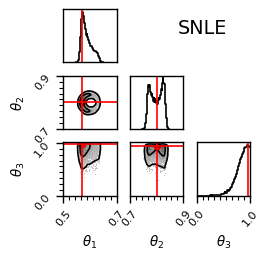

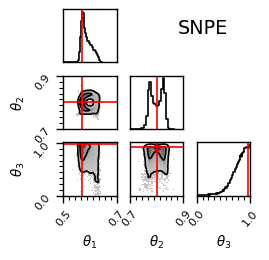

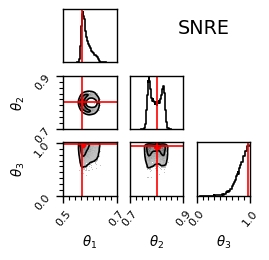

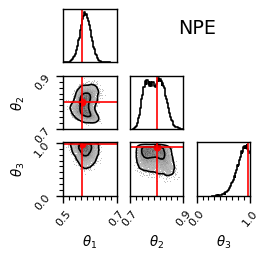

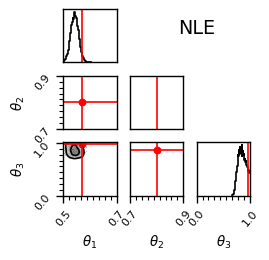

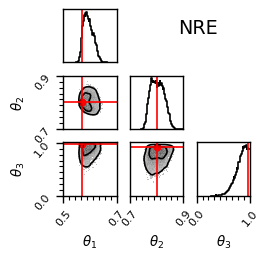

In [6]:
posterior_subsamples = valmap(
    compose(get_xmany(30000), lambda x: x.numpy()),
    posterior_samples
)
posterior_subsamples = keyfilter(
    lambda x: "032032" in x,
    posterior_subsamples
)
print(posterior_subsamples.keys())

matplotlib.rc_file_defaults()
sns.set_context("paper")

for k, v in posterior_subsamples.items():
    marginals = tmnre.marginalize.all_marginals(v)
    dfs = swyft.utils.get_df_dict_from_marginals(marginals)
    fig, axes = cc.corner(
        dfs,
        **kwargs,
    )

    # ylim
    axes[1, 0].set_ylim(0.7, 0.9)
    axes[2, 0].set_ylim(0.0, 1.01)
    
    ya, yb = axes[2, 0].get_ylim()
    axes[2, 0].set_ylim(0.0, yb)

    # xlim
    axes[2, 0].set_xlim(0.5, 0.7)
    axes[2, 1].set_xlim(0.7, 0.9)
    axes[2, 2].set_xlim(0.0, 1.01)

    # yticks
    for ax in axes[1:, 0]:
        start, stop = ax.get_ylim()
        stop = stop if stop <= 1.0 else 1.0
        ax.yaxis.set_ticks(np.linspace(start, stop, num=2))
        ax.yaxis.set_major_formatter('{x:0.1f}')
        ax.yaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

    # xticks
    for ax in axes[2, :]:
        start, stop = ax.get_xlim()
        ax.xaxis.set_ticks(np.linspace(start, stop, num=2))
        ax.xaxis.set_major_formatter('{x:0.1f}')
        ax.xaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)
    
    plt.figtext(
        s=k.split()[0],
        x=0.6,
        **fittext_kwargs,
    )

    fig.savefig(f"figures/torus-{k.replace(' ', '-')}-corner.png", bbox_inches='tight', dpi=300)

dict_keys(['SNLE 032032', 'SNPE 032032', 'SNRE 032032', 'NPE 032032', 'NLE 032032', 'NRE 032032'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.88s/it]


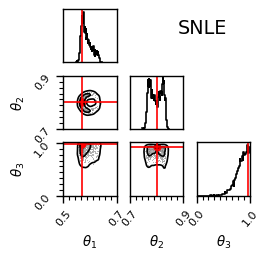

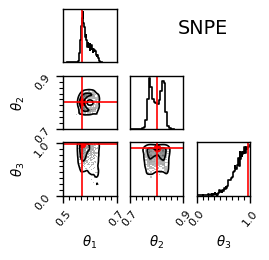

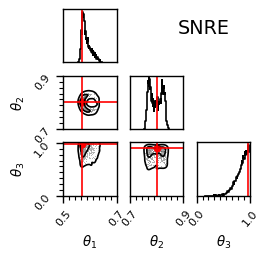

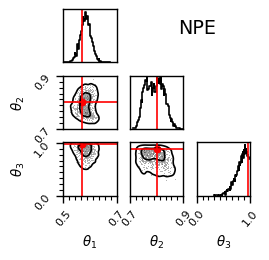

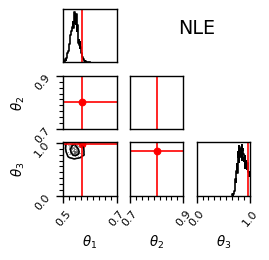

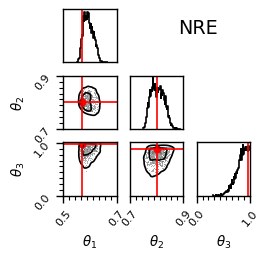

In [7]:
posterior_subsamples = valmap(
    compose(get_xmany(5000), lambda x: x.numpy()),
    posterior_samples
)
posterior_subsamples = keyfilter(
    lambda x: "032032" in x,
    posterior_subsamples
)
print(posterior_subsamples.keys())

matplotlib.rc_file_defaults()
sns.set_context("paper")

for k, v in posterior_subsamples.items():
    marginals = tmnre.marginalize.all_marginals(v)
    dfs = swyft.utils.get_df_dict_from_marginals(marginals)
    fig, axes = cc.corner(
        dfs,
        **kwargs,
    )
    
    # ylim
    axes[1, 0].set_ylim(0.7, 0.9)
    axes[2, 0].set_ylim(0.0, 1.01)
    
    ya, yb = axes[2, 0].get_ylim()
    axes[2, 0].set_ylim(0.0, yb)

    # xlim
    axes[2, 0].set_xlim(0.5, 0.7)
    axes[2, 1].set_xlim(0.7, 0.9)
    axes[2, 2].set_xlim(0.0, 1.01)

    # yticks
    for ax in axes[1:, 0]:
        start, stop = ax.get_ylim()
        stop = stop if stop <= 1.0 else 1.0
        ax.yaxis.set_ticks(np.linspace(start, stop, num=2))
        ax.yaxis.set_major_formatter('{x:0.1f}')
        ax.yaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

    # xticks
    for ax in axes[2, :]:
        start, stop = ax.get_xlim()
        ax.xaxis.set_ticks(np.linspace(start, stop, num=2))
        ax.xaxis.set_major_formatter('{x:0.1f}')
        ax.xaxis.set_ticks(np.linspace(start, stop, num=10), minor=True)

    plt.figtext(
        s=k.split()[0],
        x=0.6,
        **fittext_kwargs,
    )